In [1]:
%matplotlib inline

import os
import warnings
import collections
import time
from datetime import timedelta

import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
#import timeit

import plot_functions as pfn
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

print( 'tf version :', tf.__version__ )
print( 'tfp version:', tfp.__version__ )


tf version : 2.1.0
tfp version: 0.9.0
devide name: /device:GPU:0


In [2]:
# refresh via,
# stooq.com/q/d/?s=xauusd

dataset_headers = ['date-time','O','H','L','C']
dataset_dtype = 'float64'
dataset_dtypes = {'O':dataset_dtype,'H':dataset_dtype,'L':dataset_dtype,'C':dataset_dtype}
dataset_file = 'xauusd_d.csv'
dataset_sep = ','

dataset = pd.read_csv( dataset_file, sep=dataset_sep, names=dataset_headers, dtype=dataset_dtypes )
dataset['date-time'] =  pd.to_datetime( dataset['date-time'], format='%Y-%m-%d')

dataset = dataset.set_index( ['date-time'] )

dataset = dataset.resample('D').pad()
dataset.tail( 5 )


,O,H,L,C
date-time,,,,
2020-02-17,1582.40,1583.82,1578.93,1581.30
2020-02-18,1584.33,1605.15,1582.51,1601.62
2020-02-19,1601.68,1613.16,1599.60,1611.76
2020-02-20,1612.29,1623.90,1604.06,1619.63
2020-02-21,1620.57,1649.16,1618.79,1643.37


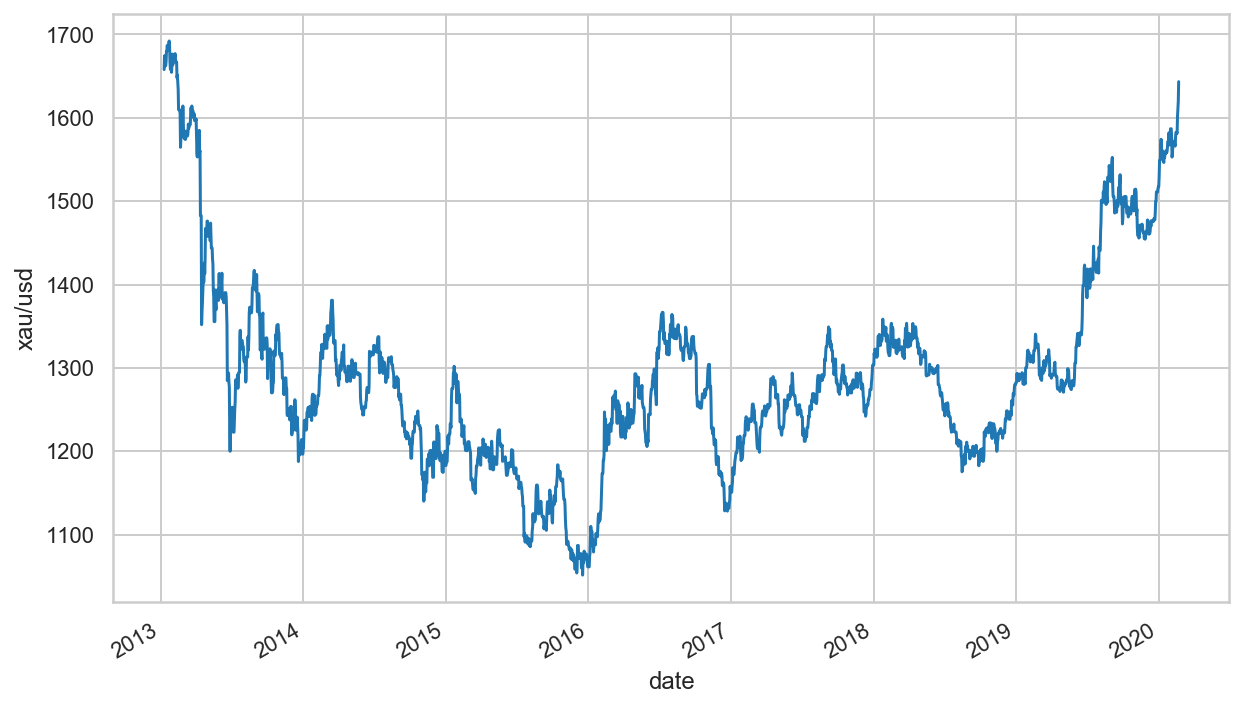

In [3]:
num_forecast_steps = 30
baseline_window    = 2600

close_price=dataset['C'][-baseline_window:]
close_dates=dataset.index[-baseline_window:]

fig = plt.figure( figsize=(10,6) )
ax = fig.add_subplot( 1, 1, 1 )
ax.plot( close_price, label="training data" )
ax.set_ylabel("xau/usd")
ax.set_xlabel("date")
fig.autofmt_xdate()


In [4]:
def build_model( observed_time_series ):
  
    baseline = sts.SemiLocalLinearTrend( 
        observed_time_series=observed_time_series, 
        name='baseline' 
    )
    weekly = sts.Seasonal( 
        num_seasons=52,
        num_steps_per_season=7, 
        observed_time_series=observed_time_series,
        name='weekly'
    )
    monthly = sts.Seasonal( 
        num_seasons=12,
        num_steps_per_season=30, 
        observed_time_series=observed_time_series,
        name='monthly'
    )
    residual = sts.Autoregressive(
        order=2,
        observed_time_series=observed_time_series, 
        name='residual'
    )

    model = sts.Sum( [ baseline, weekly, monthly, residual ], observed_time_series=observed_time_series )
    return model


In [5]:
close_model = build_model( close_price )
posteriors = sts.build_factored_surrogate_posterior( model=close_model )


Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [ ]:
optimizer = tf.optimizers.Adam( learning_rate=0.05 )
num_variational_steps = 120
is_train_with_vi = True

def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior( 
        target_log_prob_fn = close_model.joint_log_prob( observed_time_series = close_price ),
        surrogate_posterior = posteriors,
        optimizer = optimizer,
        num_steps = num_variational_steps )
    return elbo_loss_curve

def train_with_hmc():
    q_samples,kernel_results = tfp.sts.fit_with_hmc(
        model = close_model,
        observed_time_series = close_price,
        num_variational_steps = num_variational_steps,
        variational_optimizer = optimizer,
        variational_sample_size = 1
    )
    print( "acceptance rate: {}".format( np.mean( kernel_results.inner_results.inner_results.is_accepted, axis=0 ) ) )
    return q_samples

starttime = time.time()
if is_train_with_vi:
    
    elbo_loss_curve = train()
    q_samples = posteriors.sample( 30 )

    plt.plot( elbo_loss_curve )

else:
    
    q_samples = train_with_hmc()

print( 'time: ', time.time() - starttime )


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
Previously, `initial_step` would return the value passed to the constructor, even if that value was not `Tensor`-like. This behavior is now deprecated. In the future, it will always return a `Tensor`-like object.


In [ ]:
print( 'inferred parameters')
print( '-------- ----------')

if is_train_with_vi:
    for param in close_model.parameters:
        print( "{}\t: {} +- {}".format( param.name, np.mean(q_samples[param.name], axis=0), np.std(q_samples[param.name], axis=0)))
else:
    for index,param in enumerate(close_model.parameters):
        print( "{}\t: {} +- {}".format( param.name, np.mean(q_samples[index], axis=0), np.std(q_samples[index], axis=0)))
    

In [8]:
close_forecast_dist = sts.forecast( 
    close_model, 
    observed_time_series = close_price,
    parameter_samples = q_samples, 
    num_steps_forecast = num_forecast_steps 
)

num_samples = 60
close_forecast_mean, close_forecast_scale, close_forecast_samples = (
    close_forecast_dist.mean().numpy()[...,0],
    close_forecast_dist.stddev().numpy()[...,0],
    close_forecast_dist.sample(num_samples).numpy()[...,0]
)


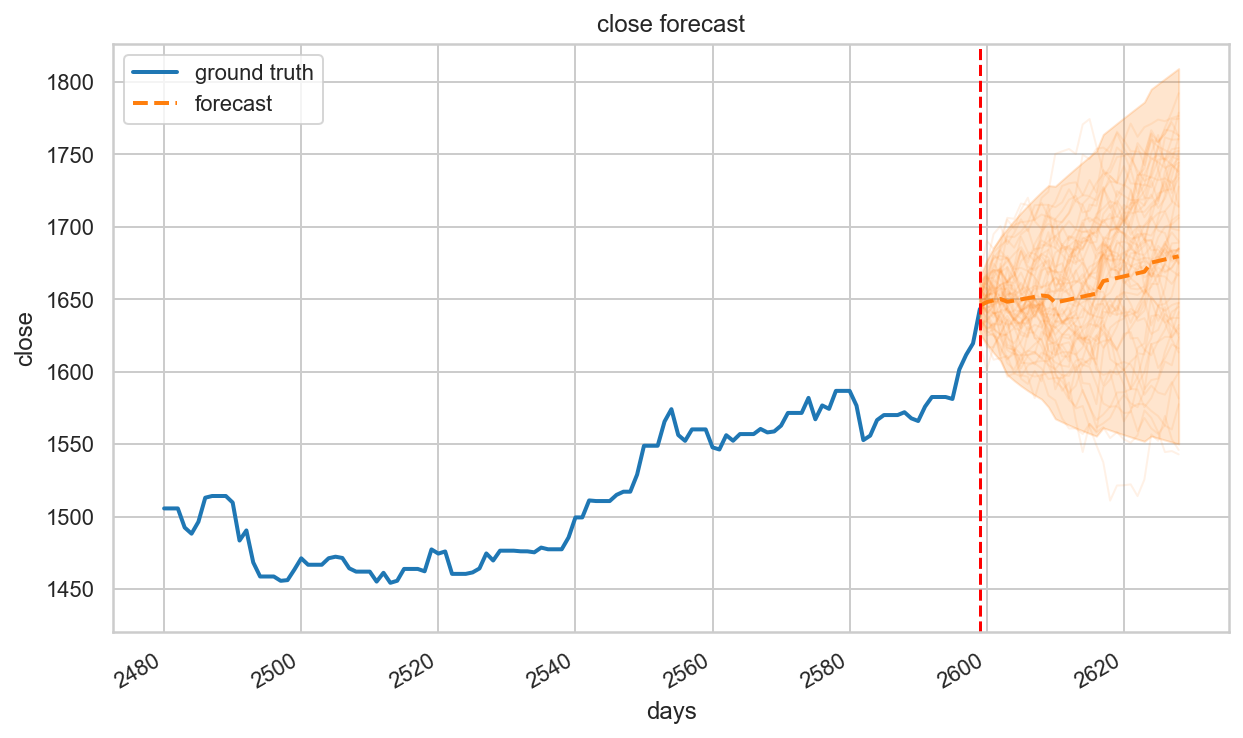

In [9]:
close_index = np.arange(start=0,stop=baseline_window)

fig,ax = pfn.plot_future_forecast_v2(
    close_index[-120:], 
    close_price[-120:],
    close_forecast_mean, 
    close_forecast_scale, 
    close_forecast_samples,
    title='close forecast',
    add_forecast_steps = num_forecast_steps
)

ax.axvline( close_index[-1], linestyle="--", color="red" )
ax.legend( loc="upper left" )
ax.set_ylabel("close")
ax.set_xlabel("days")
fig.autofmt_xdate()


In [10]:
close_forecast_mean[-1]

1679.7737733689387

In [12]:
with tf.device(  '/device:CPU:0' ):
    
    component_dists = sts.decompose_by_component( 
        close_model, 
        observed_time_series=close_price, 
        parameter_samples=q_samples
    )    
    close_component_means, close_component_stddevs = (
        {k.name: c.mean() for k, c in component_dists.items()},
        {k.name: c.stddev() for k, c in component_dists.items()}
    )


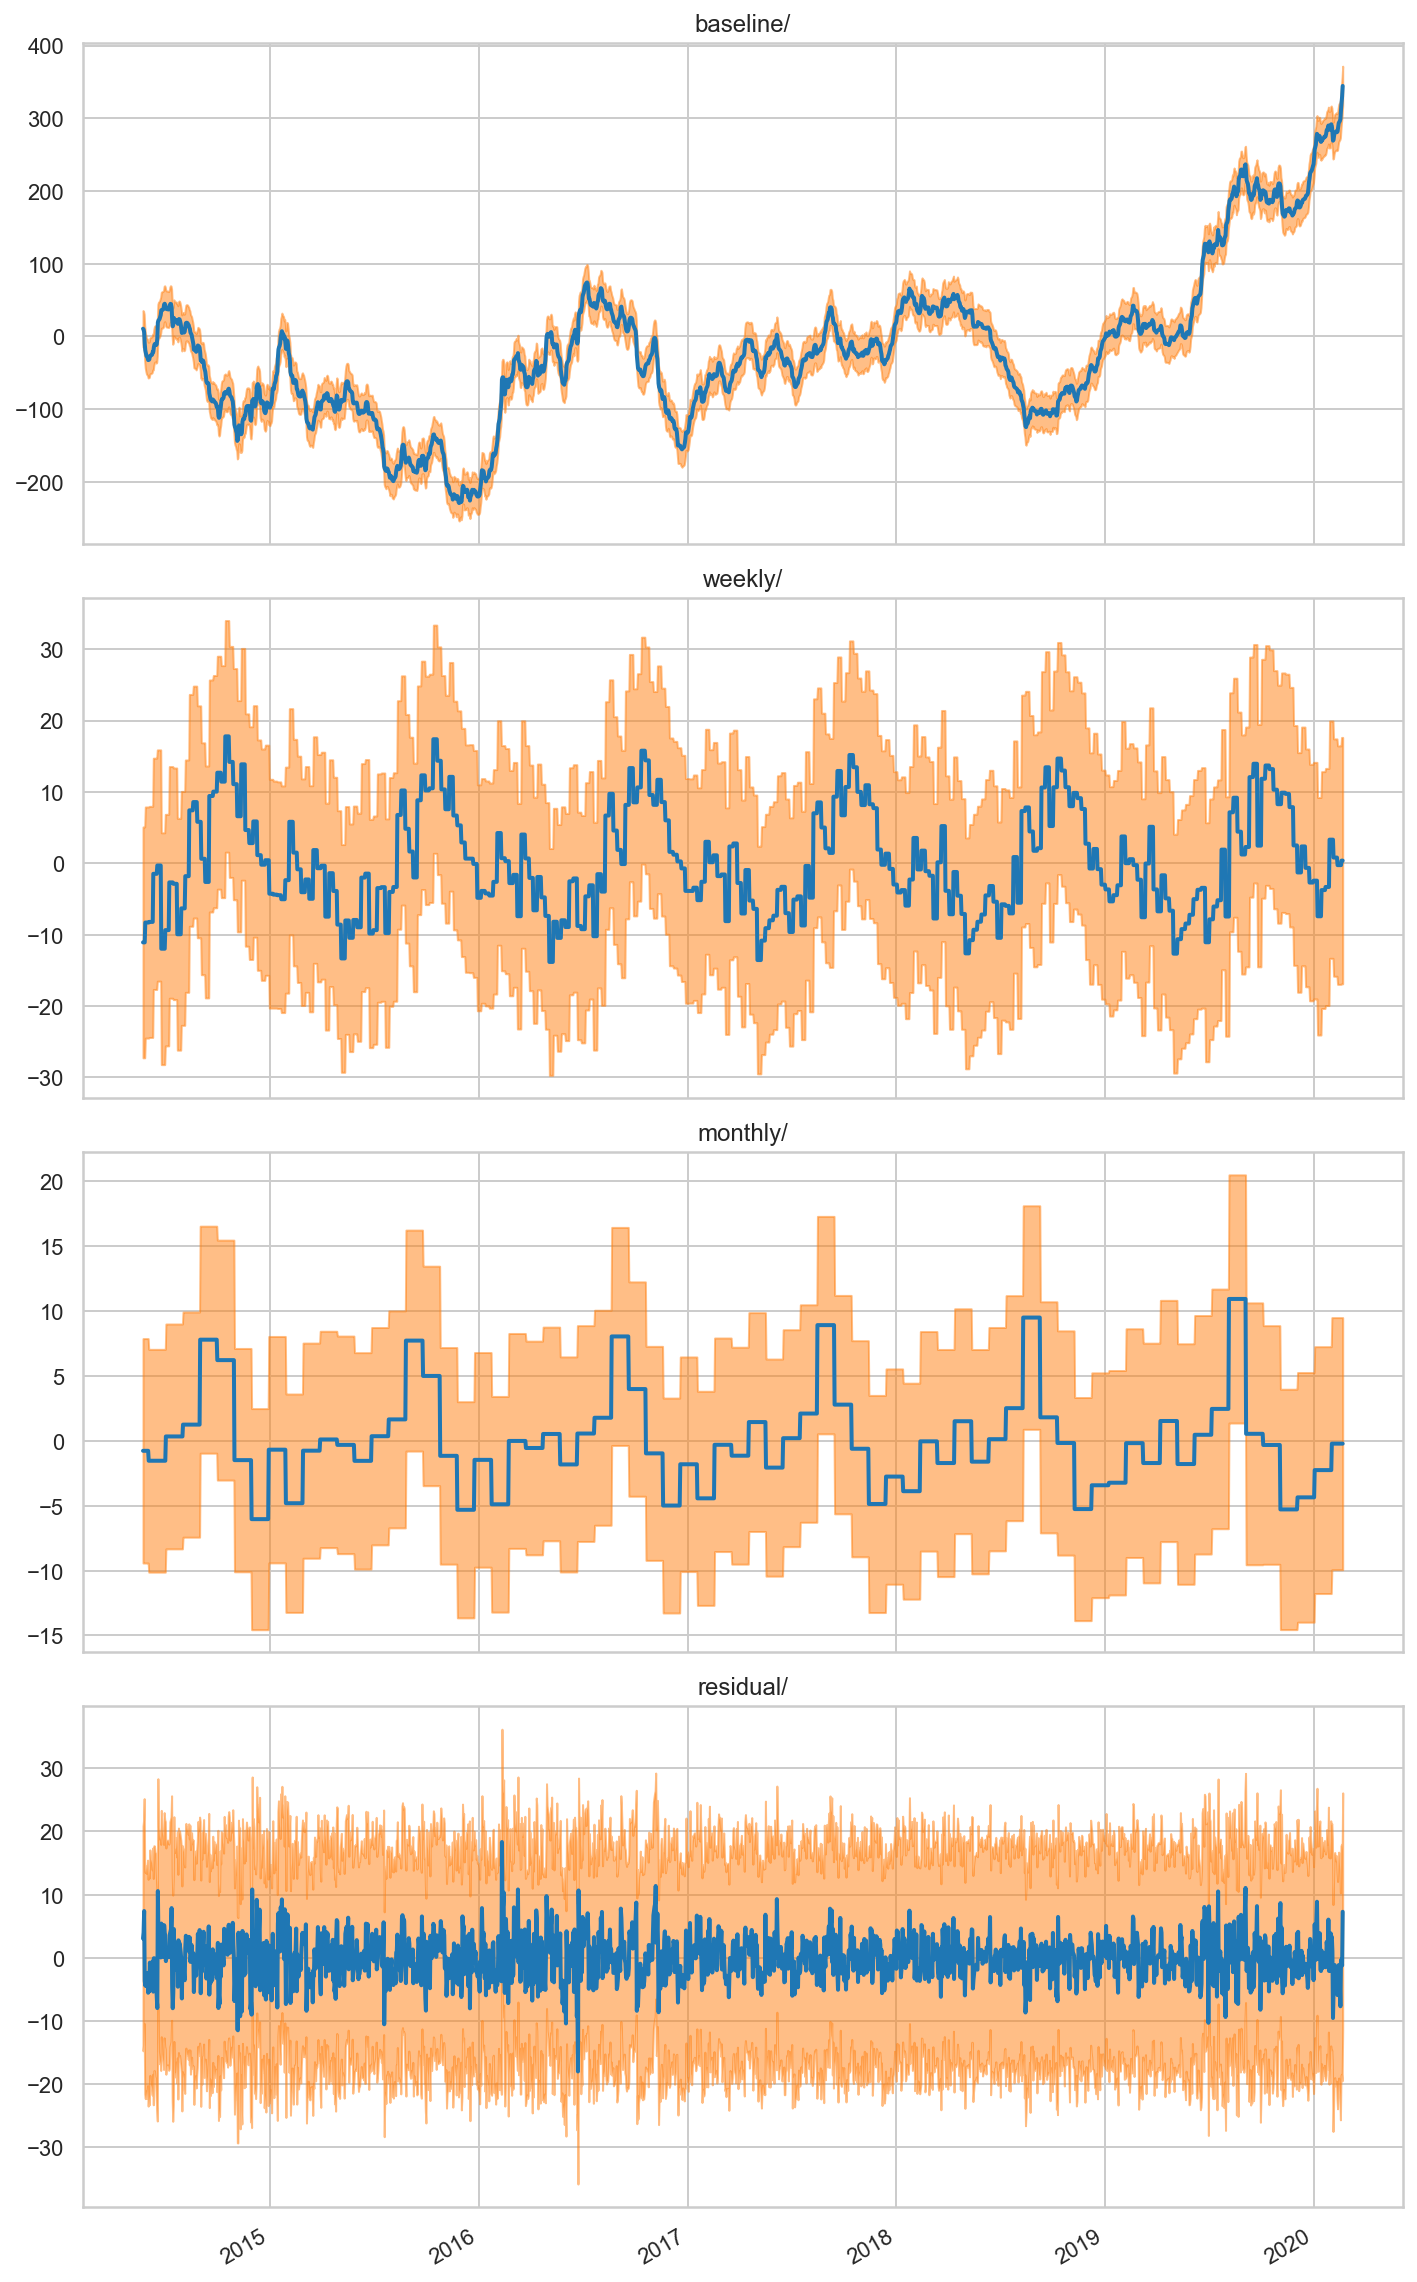

In [13]:
_ = pfn.plot_components_trim( close_dates, close_component_means, close_component_stddevs, clip=500 )


In [14]:
with tf.device(  '/device:CPU:0' ):

    forecast_component_dists = sts.decompose_forecast_by_component(
        close_model,
        forecast_dist=close_forecast_dist,
        parameter_samples=q_samples
    )
    forecast_component_means, forecast_component_stddevs = (
        {k.name: c.mean() for k, c in forecast_component_dists.items()},
        {k.name: c.stddev() for k, c in forecast_component_dists.items()}
    )
    

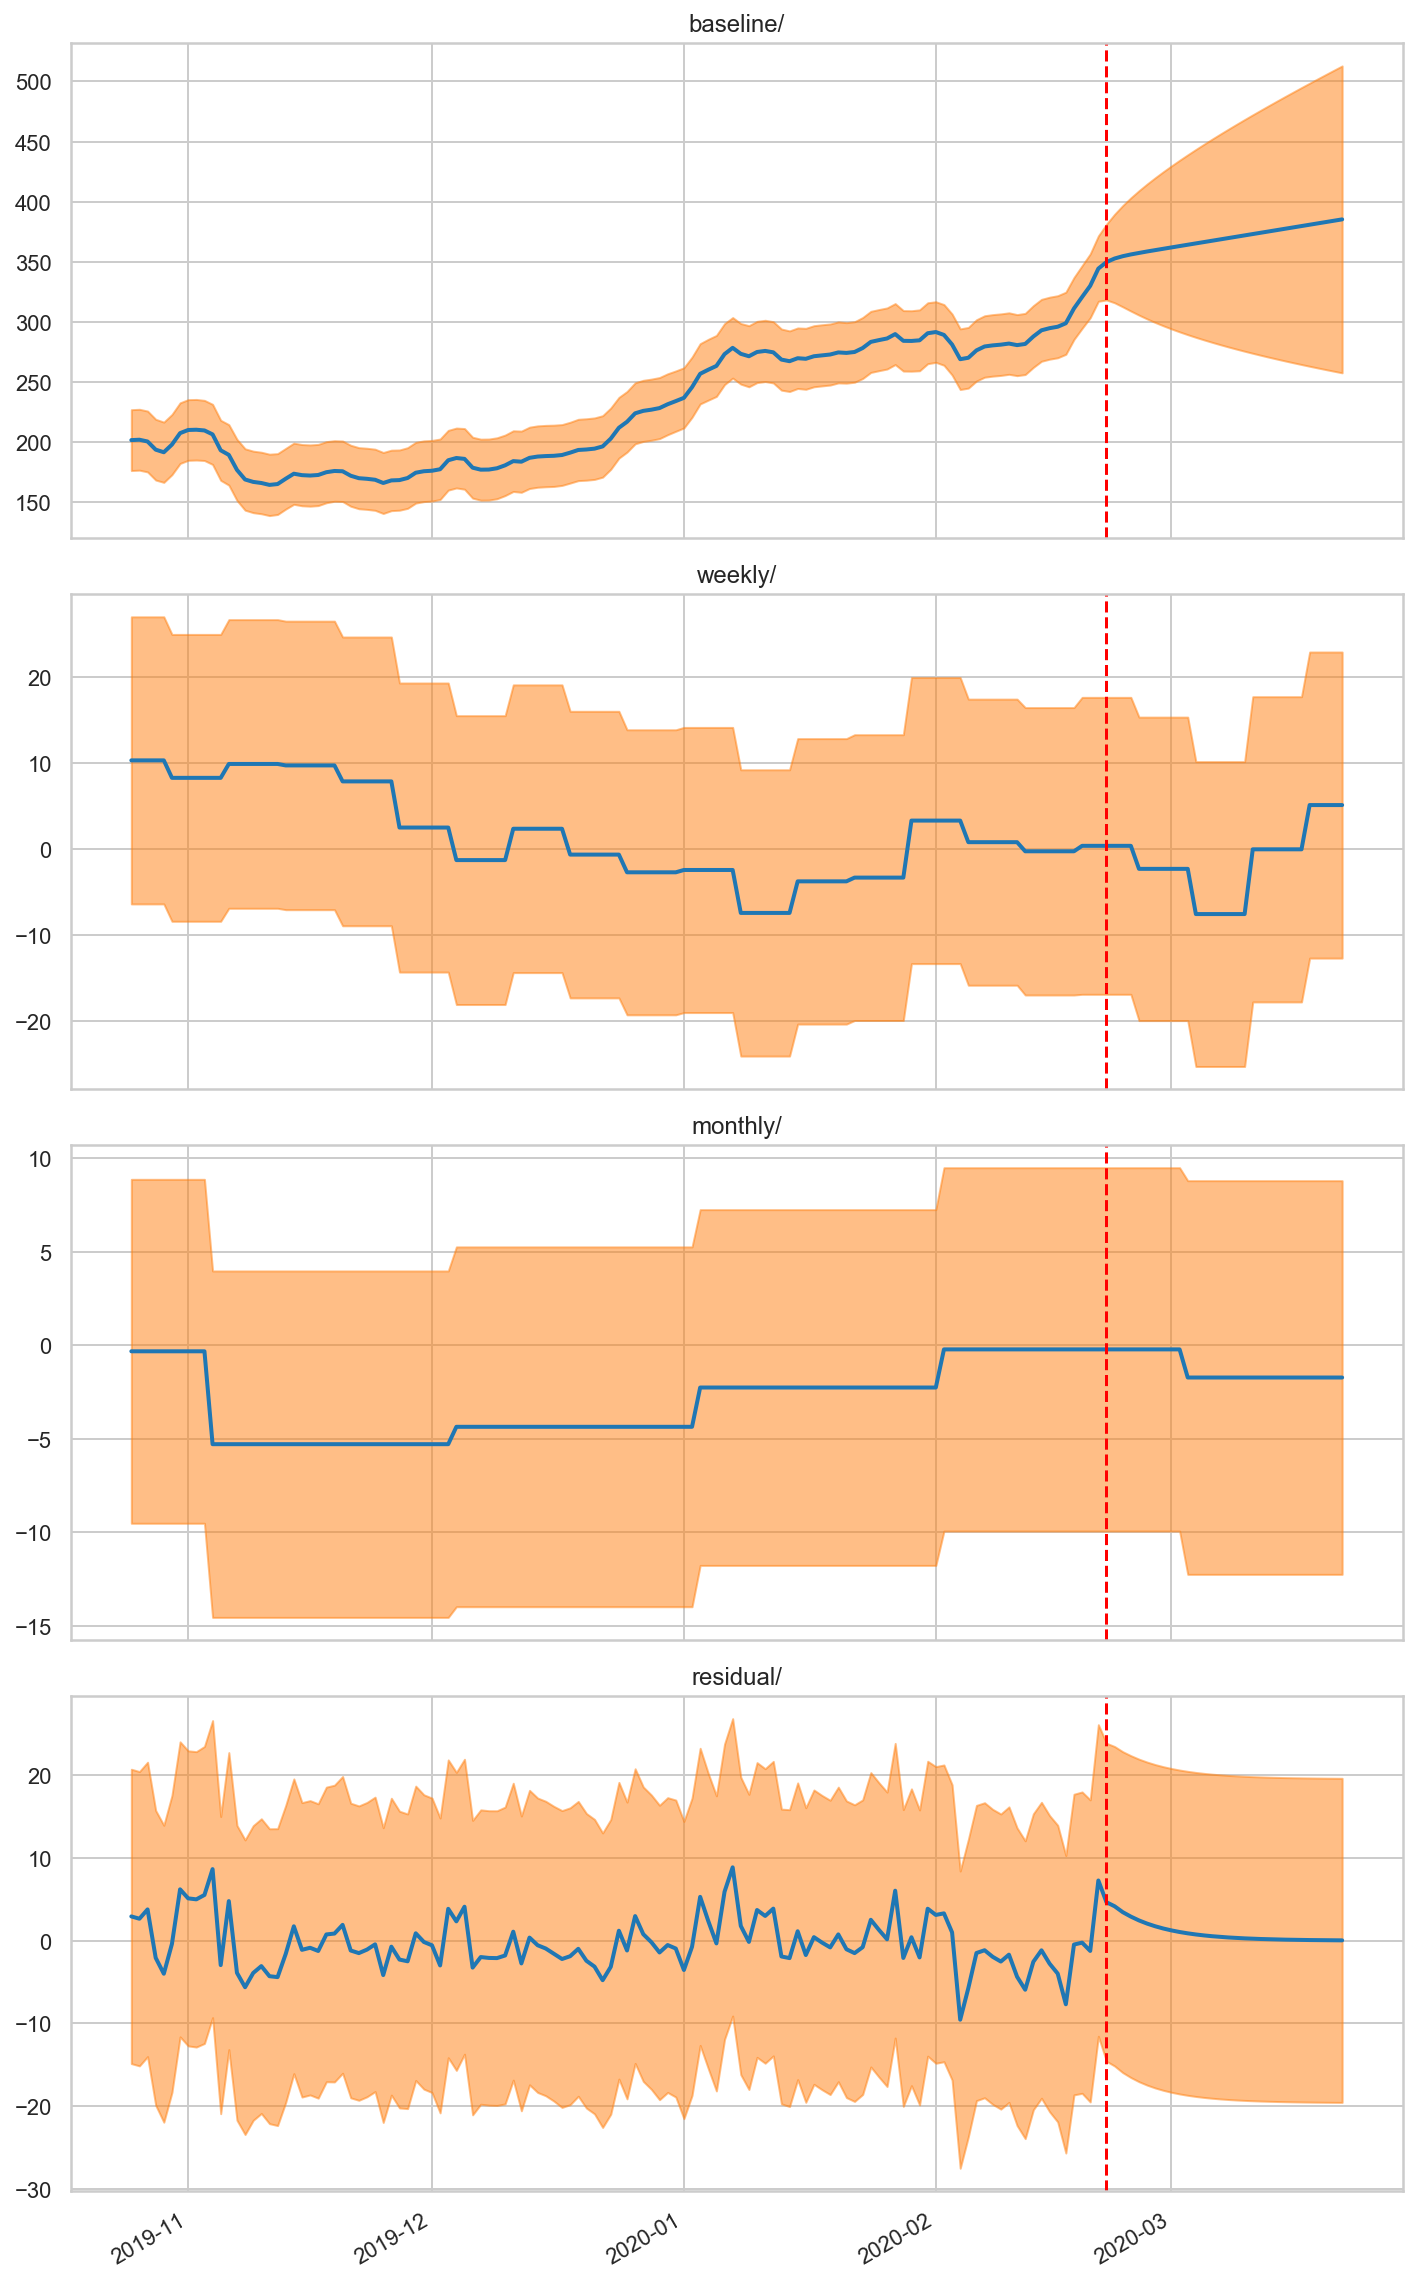

In [15]:
component_with_forecast_means = collections.OrderedDict()
component_with_forecast_stddevs = collections.OrderedDict()

for k in close_component_means.keys():
    component_with_forecast_means[k] = np.concatenate(
        [
            close_component_means[k],
            forecast_component_means[k]
        ], 
        axis=-1 
    )
    component_with_forecast_stddevs[k] = np.concatenate(
        [
            close_component_stddevs[k],
            forecast_component_stddevs[k]
        ], 
        axis=-1
    )

close_dates_plus = np.arange( close_dates[0], close_dates[-1] + timedelta(days=(num_forecast_steps+1)), dtype='datetime64[D]' )
fig, axes = pfn.plot_components_trim( close_dates_plus, component_with_forecast_means, component_with_forecast_stddevs, clip=baseline_window-120 )

for ax in axes.values():
    ax.axvline( close_dates_plus[-num_forecast_steps], linestyle="--", color='red')
    